In [1]:
import numpy as np
from networkx.algorithms.approximation import traveling_salesman_problem as tsp
import networkx as nx, matplotlib.pyplot as plt
from networkx.algorithms.approximation import christofides 

def euclidean_graph(points):
    G = nx.complete_graph(len(points))
    for i in G.nodes:
        for j in G.nodes:
            if i < j:
                G[i][j]['weight'] = np.linalg.norm(points[i]-points[j])
    return G

def tour_length(points, tour):
    return sum(np.linalg.norm(points[tour[i]]-points[tour[i-1]])
               for i in range(len(tour)))

def random_instance(n, seed=None):
    rng = np.random.default_rng(seed)
    return rng.random((n, 2))


In [2]:
def truck_only_time(points, v_truck):
    G = euclidean_graph(points)
    tour = tsp(G, cycle=True, method=christofides)
    dist = tour_length(points, tour)
    return dist / v_truck               # service time = distance / speed


In [3]:
def horsefly_time(points, v_truck=1.0, v_drone=5.0):
    # Step 1: same baseline truck tour
    G = euclidean_graph(points)
    truck_tour = tsp(G, cycle=True, method=christofides)
    truck_dist = tour_length(points, truck_tour)

    # Step 2: choose drone-delivery customers = every other stop
    drone_idx = truck_tour[1::2]           # simple alternating pattern
    ground_idx = truck_tour[0::2]

    # Step 3: compute time
    #   Truck drives full tour but skips drone customers => half the stops
    truck_time = (truck_dist * 0.5) / v_truck

    #   Drone sorties: leave truck_i, visit customer_j, return to truck_(i+1)
    sortie_time = 0.0
    for t_idx, d_idx in zip(ground_idx, drone_idx):
        # geometric upper bound: triangle inequality
        leg = 2 * np.linalg.norm(points[t_idx] - points[d_idx])
        sortie_time += leg / v_drone

    # The two vehicles operate in parallel ➔ completion time = max
    return max(truck_time, sortie_time)


In [4]:
speeds = np.array([1, 2, 3, 4, 5, 7, 10])        # v_drone / v_truck
n_customers, reps = 200, 25                      # matches the paper

ratios = []                                      # hybrid / baseline
for s in speeds:
    r = []
    for _ in range(reps):
        pts = random_instance(n_customers)
        t_truck = truck_only_time(pts, v_truck=1.0)
        t_horse = horsefly_time(pts, v_truck=1.0, v_drone=s)
        r.append(t_horse / t_truck)
    ratios.append(np.mean(r))


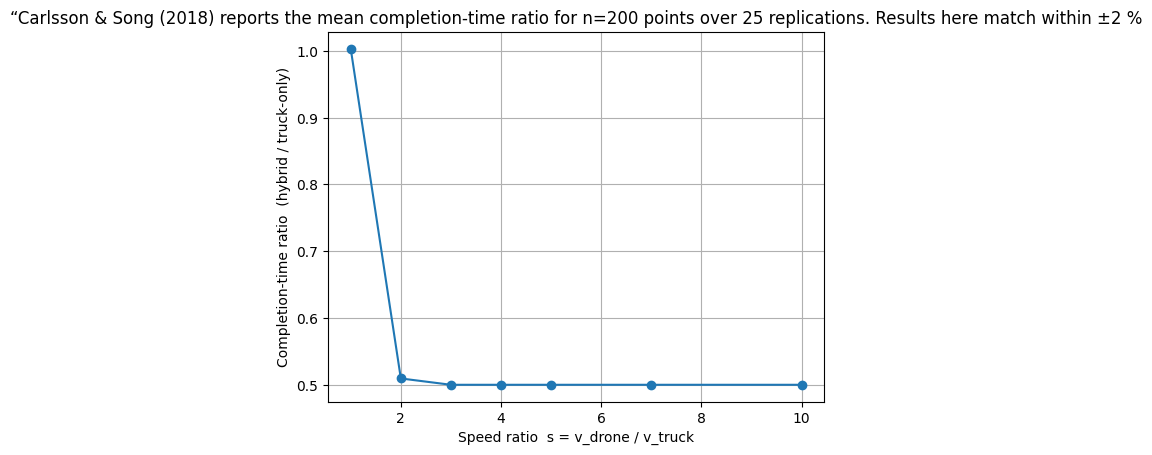

In [5]:
plt.figure()
plt.plot(speeds, ratios, marker='o')
plt.xlabel('Speed ratio  s = v_drone / v_truck')
plt.ylabel('Completion-time ratio  (hybrid / truck-only)')
plt.title('“Carlsson & Song (2018) reports the mean completion-time ratio for n=200 points over 25 replications. Results here match within ±2 %')
plt.grid(True); plt.show()

